In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from models_EF import *

In [3]:
background = np.loadtxt('data/O_cen_data_Bck_no_events.txt',usecols=(1),unpack=True)[:7]

In [4]:
print len(background)

7


In [5]:
Ener,no_events,el,er = np.loadtxt('number_of_events.txt',unpack=True)

In [6]:
#Ener,no_events,el,er = np.loadtxt('data/O_cen_data_no_events.txt',usecols=(0,1,2,3),unpack=True)

In [7]:
#Ener,no_events,el,er = Ener[:7],no_events[:7],el[:7],er[:7]

In [8]:
print len(no_events), len(background)

5 7


In [9]:
#no_events = no_events - background

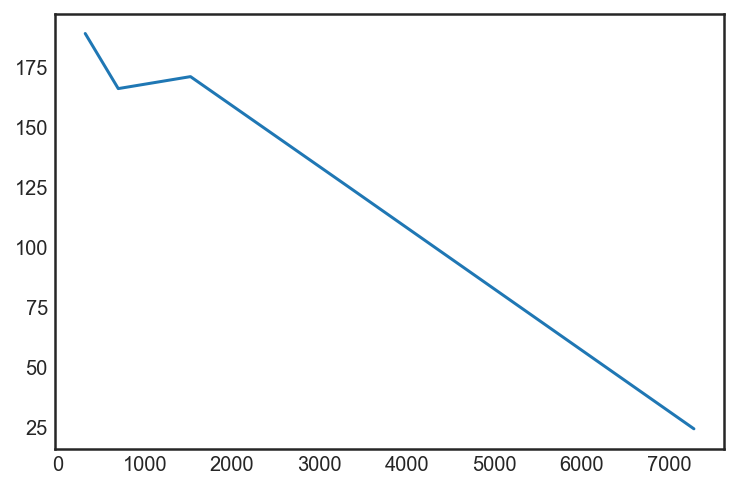

In [10]:
plt.plot(Ener,no_events);

In [11]:
e_min = Ener - el
e_max = Ener + er

In [12]:
print e_min
print e_max

[ 200.          437.34484863  956.35247803 2091.27905273 4573.05029297]
[  437.34484863   956.35247803  2091.27905273  4573.05029297
 10000.        ]


In [13]:
from scipy import optimize as op

In [14]:
fun2 = lambda *args: -event_lnhood(*args)

In [15]:
mid_2 = [1.,3.,-6.,-6.,2.5]
bnds_2 = ((-1.,3.), (2.,4.), (-15.,0.),(-15.,0.),(0.,5.))

In [16]:
result2 = op.minimize(fun2, mid_2, args=(no_events,e_min,e_max,'p+b',None,None,None),method = 'TNC',bounds=bnds_2)

In [17]:
print result2.x

[ 1.07284675  3.25364671 -8.26776127 -4.92131954  2.45147471]


In [18]:
p_list_2 = [-1.,3., 2.,4.,-15.,0.,-15.,0.,0.,5.]

In [19]:
nwalkers = 400
ndim = (len(p_list_2)/2) 

In [20]:
z = np.zeros((ndim,nwalkers))

In [21]:
h = 1e-2

pos_i=[]


for i in range(ndim):
    z[i,:] = result2.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i]]))

In [22]:
b_steps, steps = 1000, 2000

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,'p+b',p_list_2,None,None,None),
                                threads = 2)

In [24]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [25]:
print sampler.acceptance_fraction.mean()

0.482855


In [26]:
sampler.reset()

In [27]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [28]:
print sampler.acceptance_fraction.mean()

0.4810075


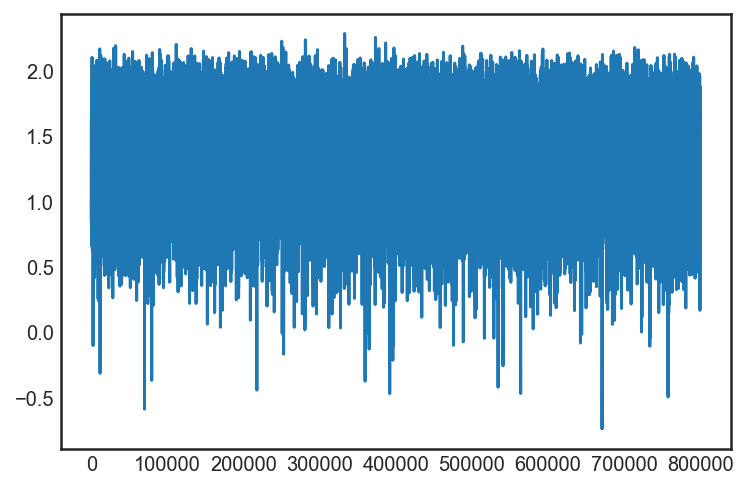

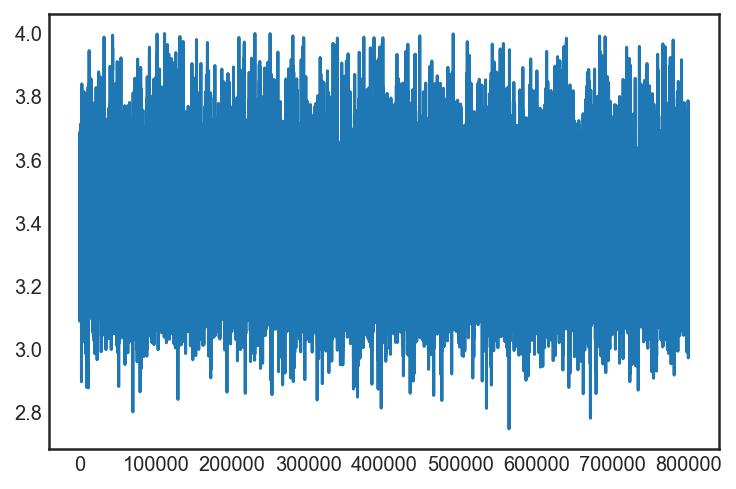

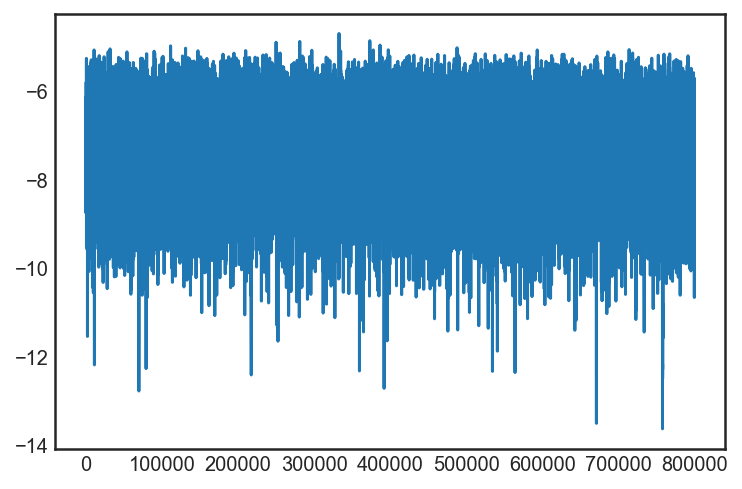

In [29]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [30]:
import corner as corner 

In [31]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)',r'$log10(N_N)$',r'$\alpha$']

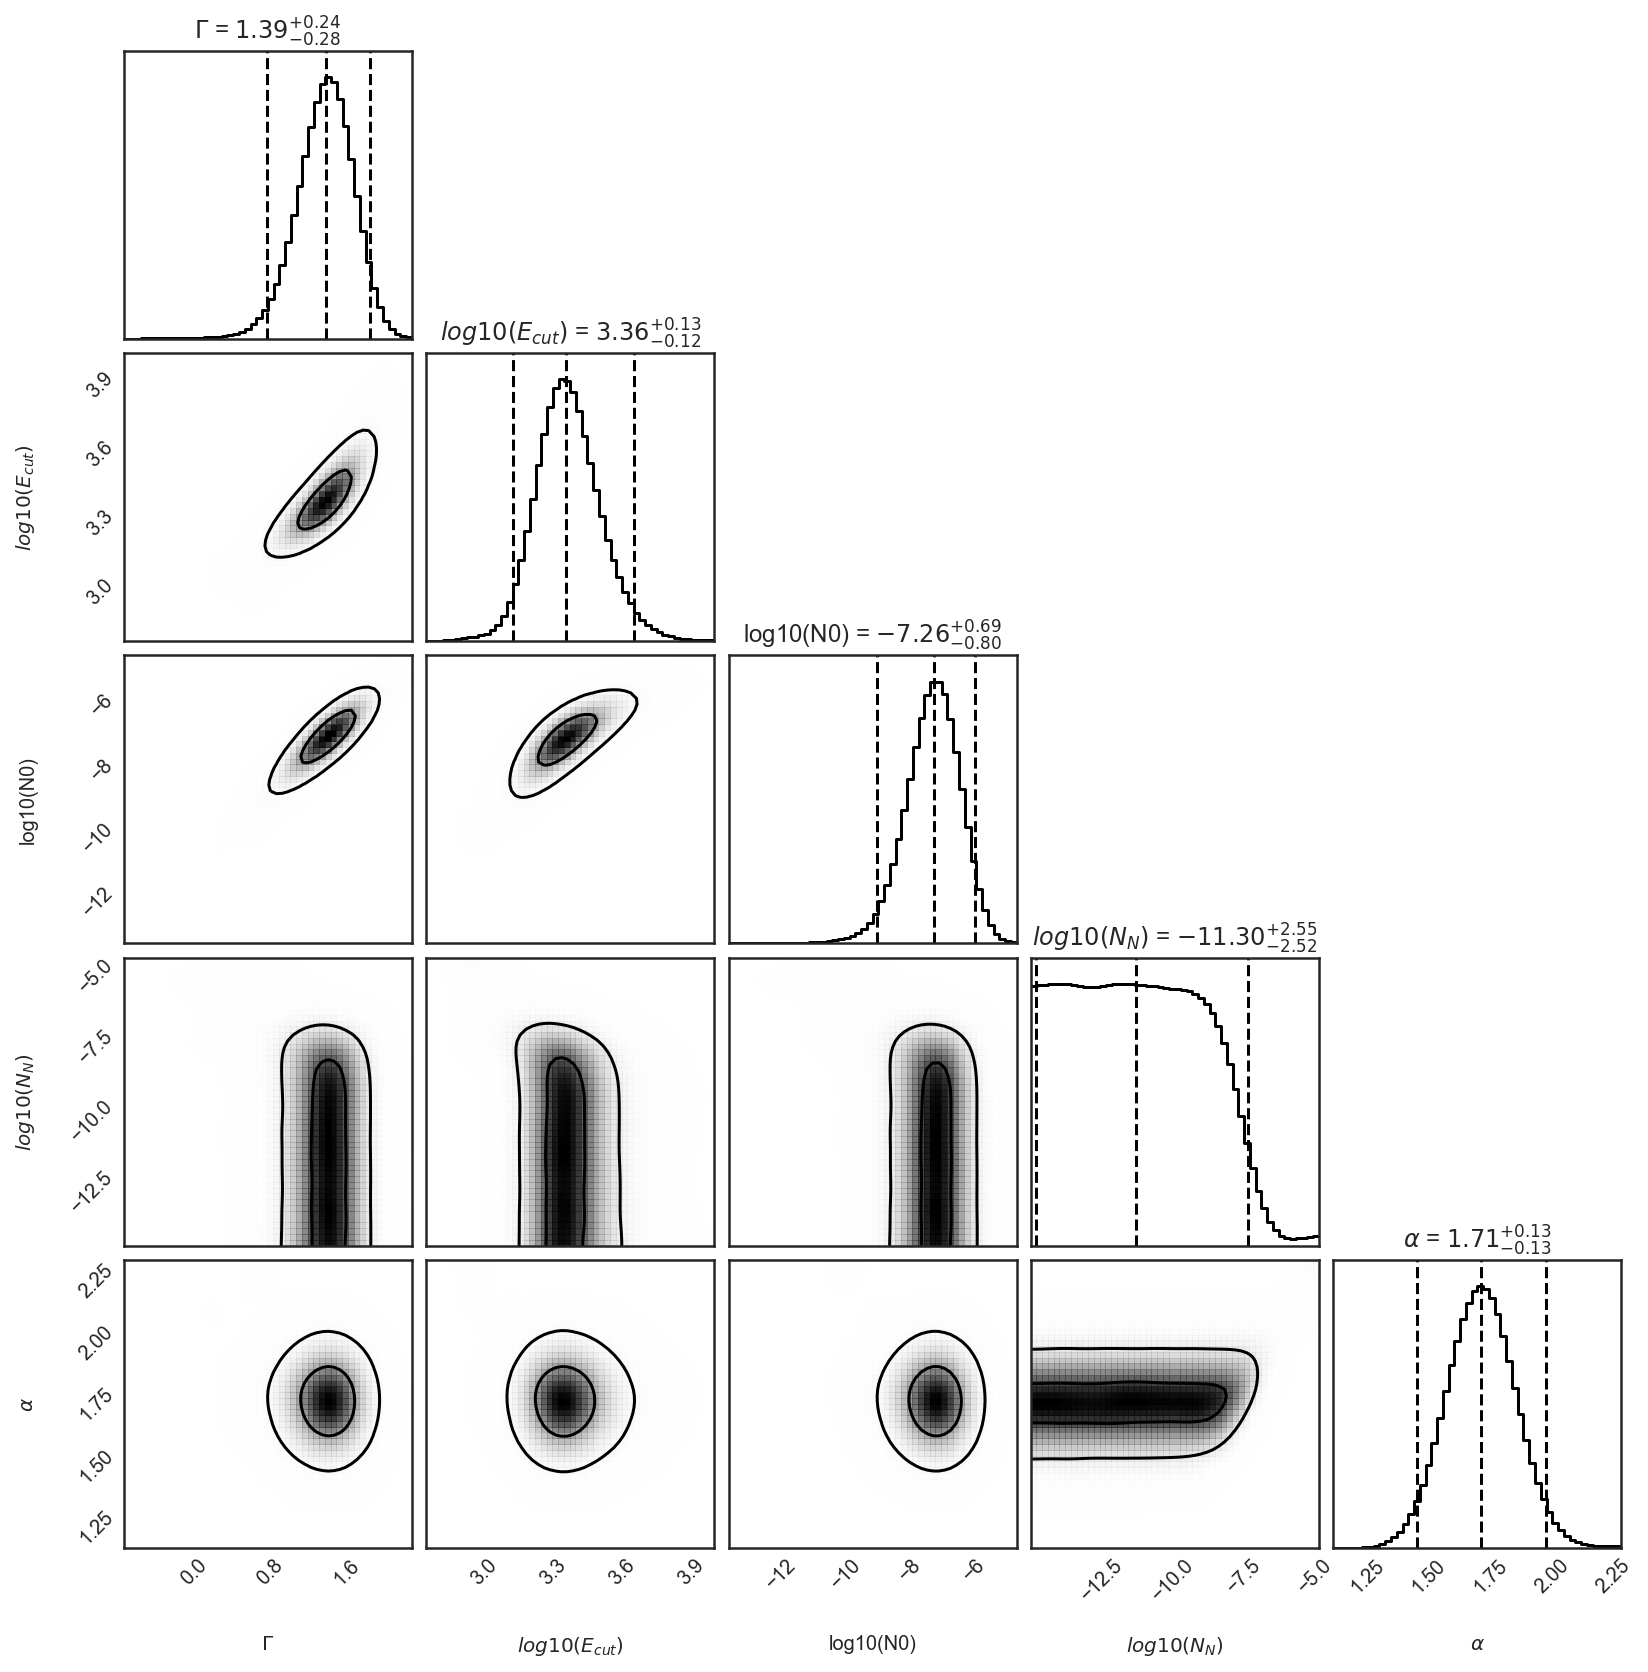

In [32]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [48]:
fig.savefig('data/data5_gauss_alpha_Ocen_psf.pdf')

In [34]:
events = no_events_model_pulsar([0.7,np.log10(2500.),1.4],e_min,e_max)

In [35]:
print events

[7.34678617e+11 3.42512023e+12 9.73262497e+12 1.20894656e+13
 5.26009711e+12]


In [36]:
10.**3.37

2344.228815319923

np.savetxt('data/chains_gauss_alpha_5.dat',sampler.flatchain)

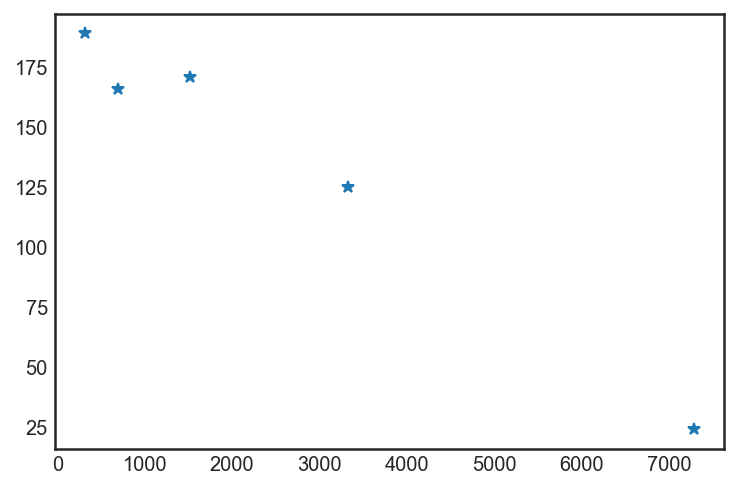

In [38]:
plt.plot(Ener,no_events,'*');

In [39]:
#events_wo_back= np.loadtxt('number_of_events_bck.txt',usecols=1,unpack=True)

Text(0,0.5,u'No_Events')

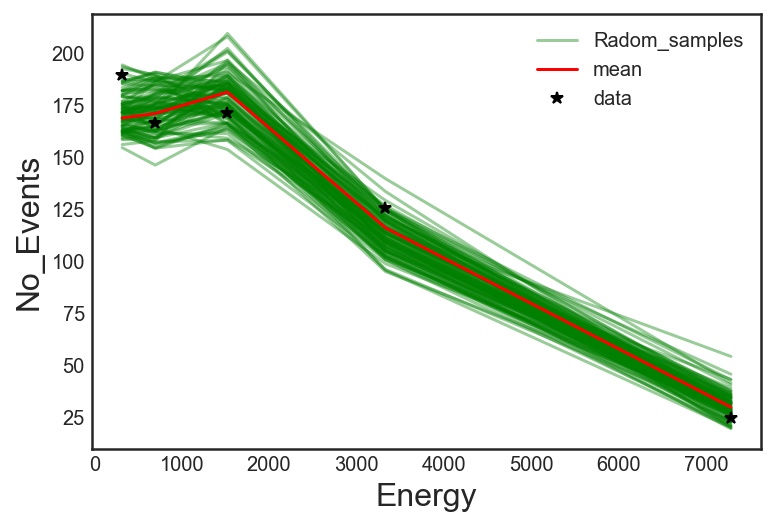

In [40]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_pulsar_complete([c1,c2,c3,c4,c5],e_min,e_max)
    fig_1,=plt.plot(Ener,val_1,'g',alpha=0.4);

val1_mean = no_events_pulsar_complete([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2]),
                                   np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4])],e_min,e_max)

fig_2,=plt.plot(Ener,val1_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.plot(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

fig1.savefig('results_data.pdf')

In [41]:
print no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)

[ 31.07065142  85.39301078 142.01746696 101.75842282  24.79760168]


In [42]:
print no_events_model_pulsar([-.6,3.9,-2.29],e_min,e_max)

[2.82319237e+11 4.00614530e+12 3.87016345e+13 2.05713924e+14
 6.02461618e+14]


In [43]:
np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])

(1.3672081635338929, 3.36408562520286, -7.323221170319168)

In [44]:
print e_min

[ 200.          437.34484863  956.35247803 2091.27905273 4573.05029297]


In [45]:
print e_max

[  437.34484863   956.35247803  2091.27905273  4573.05029297
 10000.        ]


In [46]:
print background

[110.24082894  78.7613955   47.62285019  23.67265219  10.35734039
   4.28320615   1.93644739]


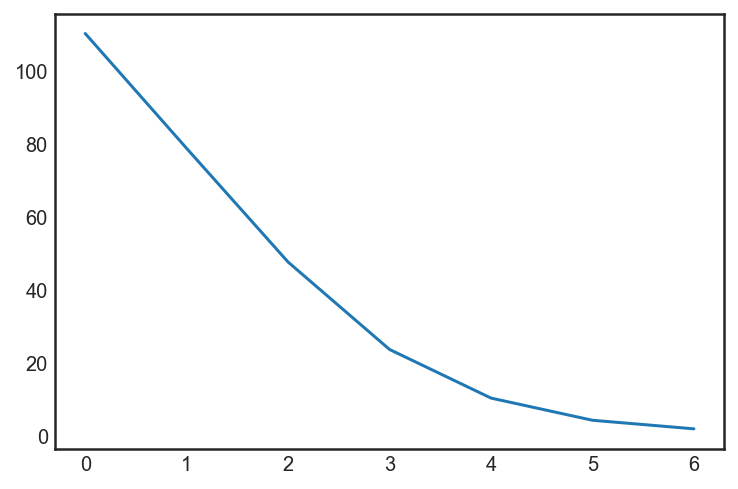

In [47]:
plt.plot(background)